In [1]:
import os

os.environ['OPENBLAS_NUM_THREADS'] = '20'
os.environ['MKL_NUM_THREADS'] = '20'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime as dt
import copy
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import xarray as xr
import pickle
import random
import time
import signal
import multiprocessing
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from scipy import interpolate
import random
import lightgbm as lgb
import itertools
from scipy import spatial
import joblib


from matplotlib import patches
from sklearn.decomposition import PCA

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sys
sys.path.insert(1,'/home/jsperezc/jupyter/AQ_Forecast/functions/')
import postprocessing
from chained_models import *

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# from gbdtmo import GBDTMulti, load_lib

In [2]:
coor_esta= pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/PM25/CoordenadasEstaciones.csv", index_col= "Nombre")


Estaciones = ["ITA-CJUS", "CAL-LASA", "ITA-CONC", "MED-LAYE", "CAL-JOAR", "EST-HOSP", "MED-ALTA", "MED-VILL", "BAR-TORR", 
              "COP-CVID", "MED-BEME", "MED-TESO", "MED-SCRI", "MED-ARAN", "BEL-FEVE", "ENV-HOSP", "SAB-RAME", "MED-SELE",
             "CEN-TRAF","SUR-TRAF"]


#coor_esta = coor_esta.drop(short_stations,axis = 0)
# coor_esta = coor_esta.loc[Estaciones]

file_gfs_ref = os.listdir("/var/data1/AQ_Forecast_DATA/historic/GFS/historic/00/")[0]
gfs_referencia = xr.open_dataset("/var/data1/AQ_Forecast_DATA/historic/GFS/historic/00/" + file_gfs_ref)  
gfs_referencia = postprocessing.recorte_espacial(gfs_referencia)

max_lag = 96 ## Maximum lag used
n_leadtime = 96
keys_gfs = ['tcc','rad','prate','hpbl','cin']

def clean_abrupt_gradient(anoms):
    diff = abs(np.diff(anoms))
    anoms[np.hstack([diff>=1.5,np.array([False])])] = np.nan
    anoms[np.hstack([np.array([False]),diff>=1.5])] = np.nan
    return pd.Series(anoms,index = anoms.index)

def get_optimal_window(variable,hour):
    return np.argmax(abs(np.load('/var/data1/AQ_Forecast_DATA/historic/GFS/correlations/CorrsAnomsGFS_'\
                                 +variable+'_v3.npy')[:,hour]))+1


In [3]:
### CAMS

data_CAMS = postprocessing.call_files('CAMS')
data_CAMS = postprocessing.recorte_espacial(data_CAMS)

dataset_full = data_CAMS

lat_cams = dataset_full.latitude.values
lon_cams = dataset_full.longitude.values

aod = np.nanmean(dataset_full.aod550.values,axis = (1,2))#[:].data
bcaod = np.nanmean(dataset_full.bcaod550.values,axis = (1,2))#[:].data
pm2p5_cams = np.nanmean(dataset_full.pm2p5.values,axis = (1,2)) #* 1000_000_000

df_cams = pd.DataFrame(np.array([aod,bcaod,pm2p5_cams]).T,index= dataset_full.time.values,
    columns = ['aod','bcaod','pm2p5_cams'])
# df_cams = pd.DataFrame(np.array([aod,pm2p5_cams]).T,index= dataset_full.time.values,
#     columns = ['aod','pm2p5_cams'])
# df_cams = (df_cams.rolling(3,center=True).mean())
df_cams.index = df_cams.index - dt.timedelta(hours = 5)


In [4]:
# df_cams.to_csv('/var/data1/AQ_Forecast_DATA/zenodo/df_cams.csv')

In [5]:
data_pm25 = pd.read_csv('/var/data1/AQ_Forecast_DATA/historic/PM25/FullPM2.5.csv',index_col=0,parse_dates=True)
short_stations = ['SAB-JOFE','MED-UNNV','GIR-TEMP','GIR-SOSN','GIR-EPM','MED-FISC']
# data_pm25.index = data_pm25.index-dt.timedelta(hours = 1) 
data_pm25 = data_pm25.drop(short_stations,axis = 1)
stations = np.sort(data_pm25.keys())
data_pm25 = data_pm25['2017-10-01':'2020-04-01']
data_pm25 = data_pm25.interpolate(limit=3)

In [6]:
ifrp = pd.read_csv("/var/data1/AQ_Forecast_DATA/historic/Fires/Processed/IFRP_Radios_800hpa_4dias.csv", 
                   usecols=[str(i) for i in np.arange(16)],index_col=0,parse_dates=True)
ifrp.columns = np.arange(50, 800, 50).astype(str)

ifrp_optimal_50 = ifrp[['50']].rolling(24).mean()

In [7]:
from denseweight import DenseWeight
# import KDEpy.kernel_funcs as kernel_funcs
# from functools import partial

class CustomMSELoss:
    def __call__(self, y_true, y_pred):
        grad = 2 * (y_pred - y_true)
        hess = 2 * np.ones_like(y_pred)
        return grad, hess

class CustomWeightedMSELoss:
    def __init__(self, weighting_function):
        self.weighting_function = weighting_function
        
    def __call__(self, y_true, y_pred):
        # Compute the weighted differences
        weighted_diff = self.weighting_function(y_true) * (y_pred - y_true)
        # Compute the weighted MSE loss
        grad = 2 * weighted_diff
        hess = 2 * self.weighting_function(y_true)
        
        return grad, hess

In [8]:
from sklearn.linear_model import Ridge

In [9]:
base_estimators = {
    'gb_ch':
         MultiOutputLGBM(**{
            'task': 'train', 
            'num_leaves': 10,
            'min_child_samples':5,
            'max_depth':10,
            'extra_trees':'true',
            'n_jobs': 20,
            'verbose': -1}),
    'gb_mo':
         MultiOutputRegressor(lgb.LGBMRegressor(**{'task': 'train',
            'num_leaves': 5,
            'min_child_samples': 80,
            'extra_trees': 'false',
            'n_jobs': 1,                               
            'verbose': -1,
            'importance_type': 'gain',
            }), n_jobs=20),
    'rf_ch':
         MultiOutputRF(**{'bootstrap': True,
             'max_samples': 0.2,
             'max_depth': 10,
             'max_features': 10,
             'n_estimators': 50,
             'n_jobs': 20}),
    'rf_mo':
         MultiOutputRegressor(RandomForestRegressor(**{'bootstrap': True,
         'max_samples': 0.4,
         'max_depth': 10,
         'max_features': 80,
         'n_estimators': 50,
         'n_jobs': 1}), n_jobs=20),
    
    'lr_rc':
         MultiOutputLR(**{'n_jobs': 1}),
    
    'lr_mo':
         MultiOutputRegressor(Ridge(), n_jobs=1)}

In [26]:
import dill

def train_estimator(X,Y,estimator,path_scaler_x=None,path_scaler_y=None,path_estimator=None,weighted_loss=False):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    if path_scaler_x!=None:
        joblib.dump(scaler_x, open(path_scaler_x, 'wb'))
    if path_scaler_y!=None:
        joblib.dump(scaler_y, open(path_scaler_y, 'wb'))
#     print(X_scaled)
    if weighted_loss==True:
        # Define DenseWeight
        dw = DenseWeight(alpha=1.15)
        weights_temp = dw.fit(Y_scaled[:,0])
        print(path_estimator)
        if '_MO' in path_estimator:
            estimator.estimator.set_params(objective=CustomWeightedMSELoss(dw))
        elif '_CH' in path_estimator:
            estimator.kwargs['objective'] = CustomWeightedMSELoss(dw)
    estimator.fit(X_scaled,Y_scaled)
    
    if path_estimator!=None:
        with open(path_estimator, 'wb') as f:
            dill.dump(estimator, f)
        
    return estimator



In [27]:
def cross_validate_estimator(X,Y,estimator,n_splits = 5,gap=96,weighted_loss=False,name_estimator = ''):
    #Scale
    scaler_x = RobustScaler().fit(X)
    scaler_y = RobustScaler().fit(Y)
    X_scaled = scaler_x.transform(X)
    Y_scaled = scaler_y.transform(Y) 
    
    #Get splits
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)
    
    mses=[]
    for train_cv, test_cv in tscv.split(X=X_scaled):
        X_train_temp = X_scaled[train_cv]
        Y_train_temp = Y_scaled[train_cv]

        X_test_temp = X_scaled[test_cv]
        Y_test_temp = Y_scaled[test_cv]
        if weighted_loss==True:
            # Define DenseWeight
            dw = DenseWeight(alpha=1.15)
            weights_temp = dw.fit(Y_scaled[:,0])
            if '_MO' in name_estimator:
                estimator.estimator.set_params(objective=CustomWeightedMSELoss(dw))
            elif '_CH' in name_estimator:
                estimator.kwargs['objective'] = CustomWeightedMSELoss(dw)
        estimator.fit(X_train_temp,Y_train_temp)
        y_model = estimator.predict(X_test_temp)
#         y_model_full = estimator.predict_random(X_test_temp)
#         for j in range(y_model_full.shape[0]):
#             y_model_full[j] = scaler_y.inverse_transform(y_model_full[j])
        y_model = scaler_y.inverse_transform(y_model)
        y_val = scaler_y.inverse_transform(Y_test_temp)
    
        mses.append(mean_squared_error(y_model,y_val))
#     return y_val,y_model, y_model_full, np.mean(mses)
    return np.mean(mses)

In [12]:
station_i = 'MED-LAYE'
print(station_i)
df_mean = pd.DataFrame(data_pm25[station_i])
df_mean.columns = ["PM25_stations"]

## Definición de la serie de tiempo de cams para cada estación (un sólo pixel)
lat_cams = dataset_full.latitude.values
lon_cams = dataset_full.longitude.values

## Station coordinates
lat_est = coor_esta.loc[station_i].Latitud
lon_est = coor_esta.loc[station_i].Longitud

df_hourly_chem = pd.concat([df_mean,df_cams],axis=1).dropna()
###Read GFS###################

latitudes, longitudes = np.array(lat_est), np.array(lon_est)
xs_gfs, ys_gfs = np.meshgrid(gfs_referencia.longitude, gfs_referencia.latitude)
arbol_binario = spatial.cKDTree(np.c_[xs_gfs.ravel(), ys_gfs.ravel()])

lxs, lys = np.meshgrid(longitudes, latitudes)
distancia, indice = arbol_binario.query([longitudes, latitudes])

lon_file = np.c_[xs_gfs.ravel(), ys_gfs.ravel()][indice][0]
lat_file = np.c_[xs_gfs.ravel(), ys_gfs.ravel()][indice][1]

df_GFS_hourly = pd.read_csv(f'/var/data1/AQ_Forecast_DATA/historic/GFS/pixel_series/GFS_{lat_file}_{lon_file}.csv',index_col = 0, parse_dates=True)
df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 1)

### PREPARA DATOS DE ENTRADA

df_optimal_cams = pd.DataFrame(index = df_hourly_chem.index)
df_optimal_cams['aod'] = df_hourly_chem.aod.rolling(3).mean()
df_optimal_cams['bcaod'] = df_hourly_chem.bcaod.rolling(1).mean()
df_optimal_cams['pm2p5_cams'] = df_hourly_chem.pm2p5_cams.rolling(3).mean()

df_optimal_gfs = pd.DataFrame(index = df_GFS_hourly.index)

for variable in keys_gfs:
    df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
    for hour in range(0,24):
        optimal_window = get_optimal_window(variable,hour)
        df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window).mean()\
            [df_optimal_temp.index.hour == hour]
    df_optimal_gfs[variable] = df_optimal_temp

df_hour = pd.DataFrame(df_hourly_chem.index.hour, index = df_hourly_chem.index)
df_hour1 = np.sin(2*np.pi*(df_hour/24))
df_hour2 = np.cos(2*np.pi*(df_hour/24))

df_dow = pd.DataFrame(df_hourly_chem.index.dayofweek, index = df_hourly_chem.index)
df_dow1 = np.sin(2*np.pi*(df_dow/7))
df_dow2 = np.cos(2*np.pi*(df_dow/7))

max_lag = 48
x_shifts = pd.concat([df_hourly_chem.PM25_stations.shift(i) for i in range(max_lag,0,-1)],axis = 1).dropna()
x_shifts.columns = np.array(['PM_'+str(i).zfill(2) for i in range(max_lag,0,-1)])

aod_future = pd.DataFrame(np.array([df_optimal_cams[['aod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['aod']].index,\
             columns = np.array(['AOD_'+str(i).zfill(2) for i in range(0,97,3)]))
bc_future = pd.DataFrame(np.array([df_optimal_cams[['bcaod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['bcaod']].index,\
             columns = np.array(['BCAOD_'+str(i).zfill(2) for i in range(0,97,3)]))
pm2p5_future = bc_future = pd.DataFrame(np.array([df_optimal_cams[['pm2p5_cams']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_cams[['pm2p5_cams']].index,\
             columns = np.array(['PMCAMS_'+str(i).zfill(2) for i in range(0,97,3)]))

tcc_future = pd.DataFrame(np.array([df_optimal_gfs[['tcc']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['tcc']].index,\
             columns = np.array(['tcc_'+str(i).zfill(2) for i in range(0,97,3)]))
rad_future = pd.DataFrame(np.array([df_optimal_gfs[['rad']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['rad']].index,\
             columns = np.array(['rad_'+str(i).zfill(2) for i in range(0,97,3)]))
prate_future = pd.DataFrame(np.array([df_optimal_gfs[['prate']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['prate']].index,\
             columns = np.array(['prate_'+str(i).zfill(2) for i in range(0,97,3)]))
hpbl_future = pd.DataFrame(np.array([df_optimal_gfs[['hpbl']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['hpbl']].index,\
             columns = np.array(['hpbl_'+str(i).zfill(2) for i in range(0,97,3)]))
cin_future = pd.DataFrame(np.array([df_optimal_gfs[['cin']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = df_optimal_gfs[['cin']].index,\
             columns = np.array(['cin_'+str(i).zfill(2) for i in range(0,97,3)]))


ifrp50_future = pd.DataFrame(np.array([ifrp_optimal_50[['50']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
             index = ifrp_optimal_50[['50']].index,\
             columns = np.array(['ifrp50_'+str(i).zfill(2) for i in range(0,97,3)]))

dow1_future = pd.DataFrame(np.array([df_dow1[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
             index = df_dow1[[0]].index,\
             columns = np.array(['dow1_'+str(i).zfill(2) for i in range(0,96,24)]))
dow2_future = pd.DataFrame(np.array([df_dow2[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
             index = df_dow2[[0]].index,\
             columns = np.array(['dow2_'+str(i).zfill(2) for i in range(0,96,24)]))

hod1_future = pd.DataFrame(np.array([df_hour1[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
             index = df_hour1[[0]].index,\
             columns = np.array(['hod1_'+str(i).zfill(2) for i in range(0,24,1)]))
hod2_future = pd.DataFrame(np.array([df_hour2[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
             index = df_hour2[[0]].index,\
             columns = np.array(['hod2_'+str(i).zfill(2) for i in range(0,24,1)]))

y_future = pd.DataFrame(np.array([df_hourly_chem[['PM25_stations']].shift(-i).values for i in range(0,96)])[:,:,0].T,\
             index = df_hourly_chem[['PM25_stations']].index,\
             columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))

### try rolling mean output # this was a winner
pm_smoothed = df_hourly_chem[['PM25_stations']].rolling(26,min_periods=16).mean()
y_future_smoothed = pd.DataFrame(np.array([pm_smoothed.shift(-i).values for i in range(0,96)])[:,:,0].T,\
             index = pm_smoothed.index,\
             columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))

X = pd.concat([x_shifts,
aod_future,
#     bc_future, NO USAR NUNCA, DAÑAN EL PRONÓSTICO :C
#     pm2p5_future,
tcc_future,
#     rad_future, meh
prate_future,
hpbl_future,
#     cin_future, meh
ifrp50_future,
dow1_future,
dow2_future,
hod1_future,
hod2_future],axis=1).dropna()

Y = y_future_smoothed.loc[X.index] 
XY = pd.concat([X,Y],axis=1).dropna()
X = XY.iloc[:,:-96]
Y = XY.iloc[:,-96:]

MED-LAYE


# Train with modified loss function

In [28]:
folder_tests = '/var/data1/AQ_Forecast_DATA/tests_revisions_paper/'
folder_estimators = f'{folder_tests}trained_estimators_v3/'
folder_scalers = f'{folder_tests}scalers_v3/'

In [29]:
# Original training/No PCA
station_names = []
estimator_names = []
cv_error = []

for estimator_name in ['gb_ch']:    
#     try:
    estimator_temp = copy.deepcopy(base_estimators[estimator_name])
    train_estimator(X,Y,estimator_temp,
                    folder_scalers+station_i+f'_X.scl',
                    folder_scalers+station_i+f'_Y.scl',
                    folder_estimators+station_i+'_'+str(estimator_name.upper())+f'.mdl',
                    weighted_loss=True)
#     estimator_to_save = train_estimator(X,Y,estimator_temp,
#                     folder_scalers+station_i+f'_X.scl',
#                     folder_scalers+station_i+f'_Y.scl',
#                     None,
#                     weighted_loss=True)
    error_temp = np.sqrt(cross_validate_estimator(X,Y, estimator_temp,weighted_loss=True,name_estimator=estimator_name))
#         aaaaa
    station_names.append(station_i)
    estimator_names.append(estimator_name)
    cv_error.append(error_temp)
#     print (estimator_temp.estimator.get_params)
    print(estimator_name,str(error_temp))
#     except Exception as e: 
#         print(e)
#         station_names.append(station_i)
#         estimator_names.append(estimator_name)
#         cv_error.append(np.nan)
# #         aaaa    
    df_errors = pd.DataFrame(columns = ['station','estimator','error'])    
    df_errors['station'] = station_names
    df_errors['estimator'] = estimator_names
    df_errors['error'] = cv_error
    df_errors.to_csv(f'{folder_tests}errors_v3/cv_stations.csv')  

/var/data1/AQ_Forecast_DATA/tests_revisions_paper/trained_estimators_v3/MED-LAYE_GB_CH.mdl
gb_ch 8.119110725515087


In [33]:
counts,bins = np.histogram(Y.iloc[:,0],bins=np.arange(0,84,4))
mid_bins = bins[:-1]+2

dw = DenseWeight(alpha=1.15)
weights_temp = dw.fit(Y.iloc[:,0].values)

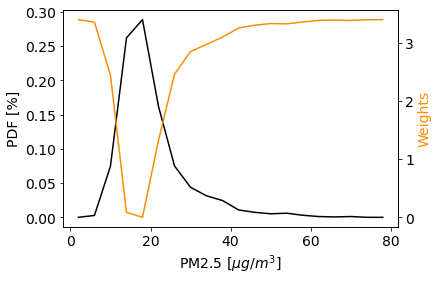

In [34]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(mid_bins,
        counts/np.sum(counts),
        color="black")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
# set x-axis label
ax.set_xlabel(r"PM2.5 [$\mu g / m^3$]", fontsize = 14)
# set y-axis label
ax.set_ylabel("PDF [%]",
              color="Black",
              fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(mid_bins,dw.eval(mid_bins),color="darkorange")
ax2.set_ylabel("Weights",color="darkorange",fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
plt.show()
# save the plot as a file
fig.savefig('Figures/WeightsPDF.png',
            dpi=100,
            bbox_inches='tight')

In [9]:
### To validation errors dataframe:

station_names = []
estimator_names = []
cv_error = []

for station_i in Estaciones[:]:
    print(station_i)
    df_mean = pd.DataFrame(data_pm25[station_i])
    df_mean.columns = ["PM25_stations"]
    
    ## Definición de la serie de tiempo de cams para cada estación (un sólo pixel)
    lat_cams = dataset_full.latitude.values
    lon_cams = dataset_full.longitude.values
    
    ## Station coordinates
    lat_est = coor_esta.loc[station_i].Latitud
    lon_est = coor_esta.loc[station_i].Longitud
    
    df_hourly_chem = pd.concat([df_mean,df_cams],axis=1).dropna()
    ###Read GFS###################
    
    latitudes, longitudes = np.array(lat_est), np.array(lon_est)
    xs_gfs, ys_gfs = np.meshgrid(gfs_referencia.longitude, gfs_referencia.latitude)
    arbol_binario = spatial.cKDTree(np.c_[xs_gfs.ravel(), ys_gfs.ravel()])
    
    lxs, lys = np.meshgrid(longitudes, latitudes)
    distancia, indice = arbol_binario.query([longitudes, latitudes])
        
    lon_file = np.c_[xs_gfs.ravel(), ys_gfs.ravel()][indice][0]
    lat_file = np.c_[xs_gfs.ravel(), ys_gfs.ravel()][indice][1]
    
    df_GFS_hourly = pd.read_csv(f'/var/data1/AQ_Forecast_DATA/historic/GFS/pixel_series/GFS_{lat_file}_{lon_file}.csv',index_col = 0, parse_dates=True)
    df_GFS_hourly.index = df_GFS_hourly.index - dt.timedelta(hours = 1)
    
    ### PREPARA DATOS DE ENTRADA

    df_optimal_cams = pd.DataFrame(index = df_hourly_chem.index)
    df_optimal_cams['aod'] = df_hourly_chem.aod.rolling(3).mean()
    df_optimal_cams['bcaod'] = df_hourly_chem.bcaod.rolling(1).mean()
    df_optimal_cams['pm2p5_cams'] = df_hourly_chem.pm2p5_cams.rolling(3).mean()

    df_optimal_gfs = pd.DataFrame(index = df_GFS_hourly.index)

    for variable in keys_gfs:
        df_optimal_temp = copy.deepcopy(df_GFS_hourly[[variable]])
        for hour in range(0,24):
            optimal_window = get_optimal_window(variable,hour)
            df_optimal_temp[df_optimal_temp.index.hour == hour] = df_GFS_hourly[[variable]].rolling(optimal_window).mean()\
                [df_optimal_temp.index.hour == hour]
        df_optimal_gfs[variable] = df_optimal_temp

    df_hour = pd.DataFrame(df_hourly_chem.index.hour, index = df_hourly_chem.index)
    df_hour1 = np.sin(2*np.pi*(df_hour/24))
    df_hour2 = np.cos(2*np.pi*(df_hour/24))

    df_dow = pd.DataFrame(df_hourly_chem.index.dayofweek, index = df_hourly_chem.index)
    df_dow1 = np.sin(2*np.pi*(df_dow/7))
    df_dow2 = np.cos(2*np.pi*(df_dow/7))
    
    max_lag = 48
    x_shifts = pd.concat([df_hourly_chem.PM25_stations.shift(i) for i in range(max_lag,0,-1)],axis = 1).dropna()
    x_shifts.columns = np.array(['PM_'+str(i).zfill(2) for i in range(max_lag,0,-1)])

    aod_future = pd.DataFrame(np.array([df_optimal_cams[['aod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_cams[['aod']].index,\
                 columns = np.array(['AOD_'+str(i).zfill(2) for i in range(0,97,3)]))
    bc_future = pd.DataFrame(np.array([df_optimal_cams[['bcaod']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_cams[['bcaod']].index,\
                 columns = np.array(['BCAOD_'+str(i).zfill(2) for i in range(0,97,3)]))
    pm2p5_future = bc_future = pd.DataFrame(np.array([df_optimal_cams[['pm2p5_cams']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_cams[['pm2p5_cams']].index,\
                 columns = np.array(['PMCAMS_'+str(i).zfill(2) for i in range(0,97,3)]))

    tcc_future = pd.DataFrame(np.array([df_optimal_gfs[['tcc']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_gfs[['tcc']].index,\
                 columns = np.array(['tcc_'+str(i).zfill(2) for i in range(0,97,3)]))
    rad_future = pd.DataFrame(np.array([df_optimal_gfs[['rad']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_gfs[['rad']].index,\
                 columns = np.array(['rad_'+str(i).zfill(2) for i in range(0,97,3)]))
    prate_future = pd.DataFrame(np.array([df_optimal_gfs[['prate']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_gfs[['prate']].index,\
                 columns = np.array(['prate_'+str(i).zfill(2) for i in range(0,97,3)]))
    hpbl_future = pd.DataFrame(np.array([df_optimal_gfs[['hpbl']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_gfs[['hpbl']].index,\
                 columns = np.array(['hpbl_'+str(i).zfill(2) for i in range(0,97,3)]))
    cin_future = pd.DataFrame(np.array([df_optimal_gfs[['cin']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = df_optimal_gfs[['cin']].index,\
                 columns = np.array(['cin_'+str(i).zfill(2) for i in range(0,97,3)]))


    ifrp50_future = pd.DataFrame(np.array([ifrp_optimal_50[['50']].shift(-i).values for i in range(0,97,3)])[:,:,0].T,\
                 index = ifrp_optimal_50[['50']].index,\
                 columns = np.array(['ifrp50_'+str(i).zfill(2) for i in range(0,97,3)]))

    dow1_future = pd.DataFrame(np.array([df_dow1[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
                 index = df_dow1[[0]].index,\
                 columns = np.array(['dow1_'+str(i).zfill(2) for i in range(0,96,24)]))
    dow2_future = pd.DataFrame(np.array([df_dow2[[0]].shift(-i).values for i in range(0,96,24)])[:,:,0].T,\
                 index = df_dow2[[0]].index,\
                 columns = np.array(['dow2_'+str(i).zfill(2) for i in range(0,96,24)]))

    hod1_future = pd.DataFrame(np.array([df_hour1[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
                 index = df_hour1[[0]].index,\
                 columns = np.array(['hod1_'+str(i).zfill(2) for i in range(0,24,1)]))
    hod2_future = pd.DataFrame(np.array([df_hour2[[0]].shift(-i).values for i in range(0,24,1)])[:,:,0].T,\
                 index = df_hour2[[0]].index,\
                 columns = np.array(['hod2_'+str(i).zfill(2) for i in range(0,24,1)]))

    y_future = pd.DataFrame(np.array([df_hourly_chem[['PM25_stations']].shift(-i).values for i in range(0,96)])[:,:,0].T,\
                 index = df_hourly_chem[['PM25_stations']].index,\
                 columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))
    
    ### try rolling mean output # this was a winner
    pm_smoothed = df_hourly_chem[['PM25_stations']].rolling(26,min_periods=16).mean()
    y_future_smoothed = pd.DataFrame(np.array([pm_smoothed.shift(-i).values for i in range(0,96)])[:,:,0].T,\
                 index = pm_smoothed.index,\
                 columns = np.array(['y_'+str(i).zfill(2) for i in range(0,96)]))
    
    X = pd.concat([x_shifts,
    aod_future,
#     bc_future, NO USAR NUNCA, DAÑAN EL PRONÓSTICO :C
#     pm2p5_future,
    tcc_future,
#     rad_future, meh
    prate_future,
    hpbl_future,
#     cin_future, meh
    ifrp50_future,
    dow1_future,
    dow2_future,
    hod1_future,
    hod2_future],axis=1).dropna()

    Y = y_future_smoothed.loc[X.index] 
    XY = pd.concat([X,Y],axis=1).dropna()
    X = XY.iloc[:,:-96]
    Y = XY.iloc[:,-96:]
    for estimator_name in base_estimators.keys():
#     for estimator_name in ['gb_mo']:    
        try:
            estimator_temp = copy.deepcopy(base_estimators[estimator_name])
            train_estimator(X,Y,estimator_temp,
             '/var/data1/AQ_Forecast_DATA/scalers/'+station_i+'_X.scl',
             '/var/data1/AQ_Forecast_DATA/scalers/'+station_i+'_Y.scl',
             '/var/data1/AQ_Forecast_DATA/trained_estimators/'+station_i+'_'+str(estimator_name.upper())+'.mdl')
            error_temp = np.sqrt(cross_validate_estimator(X,Y, estimator_temp))
    #         aaaaa
            station_names.append(station_i)
            estimator_names.append(estimator_name)
            cv_error.append(error_temp)

            print(estimator_name,str(error_temp))
        except Exception as e: 
            print(e)
            station_names.append(station_i)
            estimator_names.append(estimator_name)
            cv_error.append(np.nan)
#         aaaa    
        df_errors = pd.DataFrame(columns = ['station','estimator','error'])    
        df_errors['station'] = station_names
        df_errors['estimator'] = estimator_names
        df_errors['error'] = cv_error
        df_errors.to_csv('/var/data1/AQ_Forecast_DATA/errors/cv_stations.csv')  
#         aaaa
        

ITA-CJUS
gb_ch 6.293651601671105
gb_mo 5.474165657438489
rf_ch 5.790855894844283
rf_mo 5.607004082475734
lr_rc 5.599354420437162
lr_mo 5.599354420437219
CAL-LASA
gb_ch 7.0820772489196715
gb_mo 5.772183740615245
rf_ch 6.319362699684061
rf_mo 6.294101771084246
lr_rc 32498169429.43777
lr_mo 23417631934.920174
ITA-CONC
gb_ch 7.161476818039744
gb_mo 6.274971831367483
rf_ch 6.419206427943076
rf_mo 6.2930292338111755
lr_rc 8615469000.794703
lr_mo 6117972374.143943
MED-LAYE
gb_ch 6.601442569663542
gb_mo 5.615182544547671
rf_ch 6.099438130069412
rf_mo 5.825018145955442
lr_rc 11917796423.64993
lr_mo 10453929037.377075
CAL-JOAR
gb_ch 4.9601802114969376
gb_mo 4.459881147023231
rf_ch 5.024897550852139
rf_mo 4.692684496032424
lr_rc 4.691749581575362
lr_mo 4.691749581575356
EST-HOSP
gb_ch 5.054204025022714
gb_mo 4.20351984115832
rf_ch 4.604081773643625
rf_mo 4.267912757650718
lr_rc 13650039874.673319
lr_mo 24799928326.578674
MED-ALTA
gb_ch 4.7241772622968385
gb_mo 4.303824108220546
rf_ch 4.4130921474

In [120]:
estimator_name

'gb_mo'

In [19]:
tcc_future.shape

(53074, 33)

In [ ]:
    X = pd.concat([x_shifts,
    aod_future,
#     bc_future, NO USAR NUNCA, DAÑAN EL PRONÓSTICO :C
#     pm2p5_future,
    tcc_future,
#     rad_future, meh
    prate_future,
    hpbl_future,
#     cin_future, meh
    ifrp50_future,
    dow1_future,
    dow2_future,
    hod1_future,
    hod2_future],axis=1).dropna()

In [12]:
len(Estaciones)

20

In [173]:
hod2_future.shape

(7125, 24)

In [14]:
X.shape

(6899, 269)

In [97]:
X.shape

(7090, 96)

(7090, 96)

In [ ]:
5.63

In [ ]:
11.52
9.28
8.24

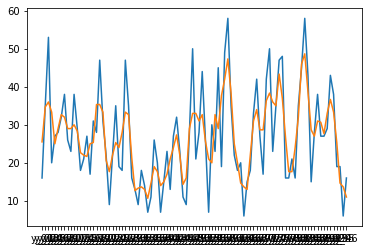

In [74]:
# random = np.random.randint(len(y_future))
plt.plot(y_future.iloc[random].values)
plt.plot(y_future.iloc[random].rolling(3,min_periods=0,center=True).mean())

In [62]:
x_shifts

,PM_48,PM_47,PM_46,PM_45,PM_44,PM_43,PM_42,PM_41,PM_40,PM_39,...,PM_10,PM_09,PM_08,PM_07,PM_06,PM_05,PM_04,PM_03,PM_02,PM_01
2017-10-07 01:00:00,41.1666,36.3121,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,...,21.1792,62.3306,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283
2017-10-07 04:00:00,36.3121,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,...,62.3306,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880
2017-10-07 07:00:00,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,...,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982
2017-10-07 10:00:00,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,...,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241
2017-10-07 13:00:00,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,20.1159,...,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241,62.9639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01 10:00:00,57.0000,46.0000,34.0000,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,...,26.0000,25.0000,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000
2020-04-01 13:00:00,46.0000,34.0000,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,38.0000,...,25.0000,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000
2020-04-01 16:00:00,34.0000,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,38.0000,46.0000,...,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000
2020-04-01 19:00:00,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,38.0000,46.0000,48.0000,...,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000,13.0000


y_01    33.499300
y_02    32.269450
y_03    35.351500
y_04    40.757133
y_05    45.780867
          ...    
y_92    43.929067
y_93    48.456433
y_94    46.321133
y_95    49.120400
y_96    55.443333
Name: 2017-10-01 10:00:00, Length: 96, dtype: float64

In [28]:
y_future.loc['2017-10-07']

,y_01,y_02,y_03,y_04,y_05,y_06,y_07,y_08,y_09,y_10,...,y_87,y_88,y_89,y_90,y_91,y_92,y_93,y_94,y_95,y_96
2017-10-07 01:00:00,27.0982,61.6241,62.9639,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,...,49.1158,52.3573,44.9329,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673
2017-10-07 04:00:00,61.6241,62.9639,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,...,52.3573,44.9329,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801
2017-10-07 07:00:00,62.9639,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,...,44.9329,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438
2017-10-07 10:00:00,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,...,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202
2017-10-07 13:00:00,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,46.1166,...,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202,48.4266
2017-10-07 16:00:00,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,46.1166,42.4184,...,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202,48.4266,53.4772
2017-10-07 19:00:00,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,46.1166,42.4184,43.5693,...,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202,48.4266,53.4772,57.7144
2017-10-07 22:00:00,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,46.1166,42.4184,43.5693,52.7347,...,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202,48.4266,53.4772,57.7144,66.8527


In [27]:
x_shifts.loc['2017-10-07']

,PM_48,PM_47,PM_46,PM_45,PM_44,PM_43,PM_42,PM_41,PM_40,PM_39,...,PM_10,PM_09,PM_08,PM_07,PM_06,PM_05,PM_04,PM_03,PM_02,PM_01
2017-10-07 01:00:00,41.1666,36.3121,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,...,21.1792,62.3306,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283
2017-10-07 04:00:00,36.3121,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,...,62.3306,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880
2017-10-07 07:00:00,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,...,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982
2017-10-07 10:00:00,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,...,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241
2017-10-07 13:00:00,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,20.1159,...,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241,62.9639
2017-10-07 16:00:00,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,20.1159,47.1654,...,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241,62.9639,25.4613
2017-10-07 19:00:00,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,20.1159,47.1654,60.1738,...,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241,62.9639,25.4613,25.5207
2017-10-07 22:00:00,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,20.1159,47.1654,60.1738,57.7340,...,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241,62.9639,25.4613,25.5207,16.6458


In [21]:
Y

,y_01,y_02,y_03,y_04,y_05,y_06,y_07,y_08,y_09,y_10,...,y_87,y_88,y_89,y_90,y_91,y_92,y_93,y_94,y_95,y_96
2017-10-07 01:00:00,27.0982,61.6241,62.9639,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,...,49.1158,52.3573,44.9329,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673
2017-10-07 04:00:00,61.6241,62.9639,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,...,52.3573,44.9329,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801
2017-10-07 07:00:00,62.9639,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,...,44.9329,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438
2017-10-07 10:00:00,25.4613,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,...,69.5560,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202
2017-10-07 13:00:00,25.5207,16.6458,61.3285,43.4795,45.7675,60.2992,61.8021,16.9598,24.9755,46.1166,...,76.0267,48.4869,53.3617,41.1576,59.9059,50.1673,45.2801,47.5438,75.2202,48.4266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20 10:00:00,44.0000,11.0000,50.0000,51.0000,46.0000,28.0000,23.0000,15.0000,12.0000,31.0000,...,25.0000,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000
2020-03-20 13:00:00,11.0000,50.0000,51.0000,46.0000,28.0000,23.0000,15.0000,12.0000,31.0000,31.0000,...,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000
2020-03-20 16:00:00,50.0000,51.0000,46.0000,28.0000,23.0000,15.0000,12.0000,31.0000,31.0000,40.0000,...,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000,13.0000
2020-03-20 19:00:00,51.0000,46.0000,28.0000,23.0000,15.0000,12.0000,31.0000,31.0000,40.0000,37.0000,...,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000,13.0000,5.0000


In [22]:
x_shifts

,PM_48,PM_47,PM_46,PM_45,PM_44,PM_43,PM_42,PM_41,PM_40,PM_39,...,PM_10,PM_09,PM_08,PM_07,PM_06,PM_05,PM_04,PM_03,PM_02,PM_01
2017-10-07 01:00:00,41.1666,36.3121,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,...,21.1792,62.3306,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283
2017-10-07 04:00:00,36.3121,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,...,62.3306,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880
2017-10-07 07:00:00,41.3737,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,...,37.6195,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982
2017-10-07 10:00:00,91.5160,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,...,38.7695,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241
2017-10-07 13:00:00,33.4993,31.0396,41.5156,49.7162,46.1108,42.4277,55.5964,68.7261,37.6014,20.1159,...,61.4680,67.4277,47.3401,26.6076,31.0271,37.9283,34.2880,27.0982,61.6241,62.9639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01 10:00:00,57.0000,46.0000,34.0000,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,...,26.0000,25.0000,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000
2020-04-01 13:00:00,46.0000,34.0000,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,38.0000,...,25.0000,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000
2020-04-01 16:00:00,34.0000,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,38.0000,46.0000,...,13.0000,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000
2020-04-01 19:00:00,50.0000,64.0000,52.0000,49.0000,61.0000,62.0000,18.0000,38.0000,46.0000,48.0000,...,22.0000,20.0000,31.0000,21.0000,10.0000,10.0000,26.0000,17.0000,9.0000,13.0000
